In [1]:
import sys
sys.path.append("/users/munozr/mycodes")
import numpy as np
import matplotlib.pyplot as plt
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import LinData
import pandas as pd
import h5py
from data_analysis_codes.tools import NumMethods
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import TAradius
from data_analysis_codes.tools import GetVars_Plot2d as GVar

In [9]:
param = RRead.read_parameters('pflrw_d3e2_L1206_t1_N64_EdS_GRH_spin_CPunc_MR')
Lin = LinData.LinData_Class(param)
FD = FD_file.FD_Class(param['dx'], param['dy'], param['dz'])
RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
get_var = GVar.Get_var(param, Lin)
fallt = pd.read_table(param['datapath']+'h5_data.csv', delimiter=',')

 read time file


In [3]:
def get_Theta(it):

    f = h5py.File('{}_it_{:06d}.hdf5'.format(param['h5datapath']+param['simname'], it), 'r')
    Kdict = get_var.get_the_curv(f, it)
    gdown = Kdict['metric_dic']['gdown']
    Gudd, Gddd = RCW.Christoffel_symbol(gdown, Kdict['metric_dic']['gup'])
    Kdown = Kdict['Kdown']
    K = Kdict['K']

    # Shift metric
    gxx = gdown[0,0]
    gxy = gdown[0,1]
    gxz = gdown[0,2]
    gyy = gdown[1,1]
    gyz = gdown[1,2]
    gzz = gdown[2,2]

    # Spherical coord
    phi = np.sign(Lin.d3y) * np.arccos(Lin.d3x / np.sqrt(Lin.d3x*Lin.d3x + Lin.d3y*Lin.d3y))
    phi[np.logical_and(np.sign(Lin.d3y) == 0.0, np.sign(Lin.d3x)<0)] = np.pi
    phi[np.where(Lin.d3x*Lin.d3x + Lin.d3y*Lin.d3y == 0)] = 0
    r = np.sqrt(Lin.d3x*Lin.d3x + Lin.d3y*Lin.d3y + Lin.d3z*Lin.d3z)
    theta = np.arccos(Lin.d3z / r)
    theta[np.where(r == 0)] = 0

    # normalisation term
    xynorm = (np.cos(phi)**2 * gxx + 2 * np.cos(phi) * np.sin(phi) * gxy + np.sin(phi)**2 * gyy)
    xyznorm = (np.sin(theta)**2 * xynorm + 2 * np.cos(theta) * np.sin(theta) * (np.cos(phi) * gxz + np.sin(phi) * gyz)+ np.cos(theta)**2 * gzz)

    # outward pointing unit vector
    Sx = np.cos(phi) * np.sin(theta) / np.sqrt(xyznorm)
    Sy = np.sin(phi) * np.sin(theta) / np.sqrt(xyznorm)
    Sz = np.cos(theta) / np.sqrt(xyznorm)
    sup = np.array([Sx, Sy, Sz])

    # Theta
    Disi = np.einsum('aa... -> ...', RCW.CovD3_tensor1up(Gudd, sup))
    Kss = np.einsum('ij..., i..., j... -> ...', Kdown, sup, sup)
    Theta_out = ( Disi - K + Kss )/np.sqrt(2)
    Theta_in = ( - Disi - K + Kss )/np.sqrt(2)
    return Theta_out, Theta_in, Kdict['metric_dic']['gdet']

In [14]:
Theta = []
allit = [0, 86800, 132400, 155200, 160000, 170000, 178000, 180000, 190000, 260400, 349800]
for it in allit:
    Theta_out, Theta_in, gdet = get_Theta(it)
    Theta += [Theta_out]

/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


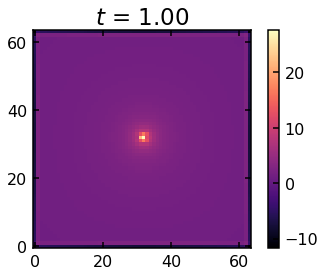

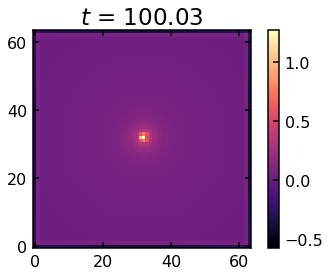

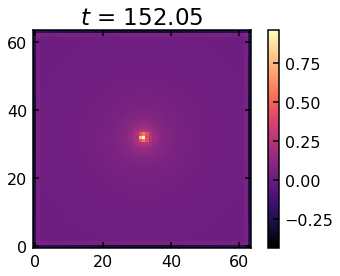

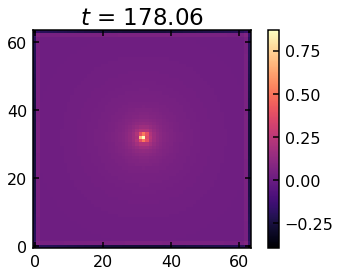

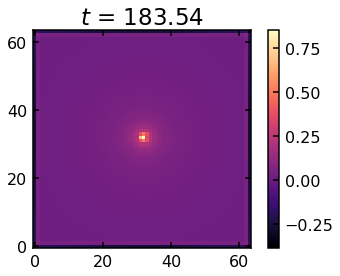

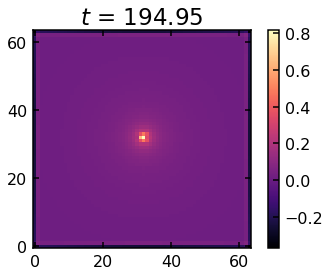

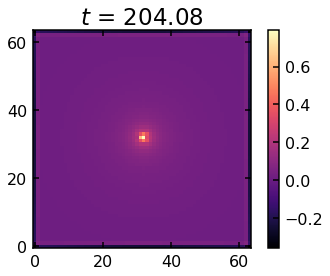

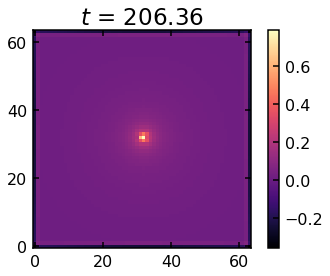

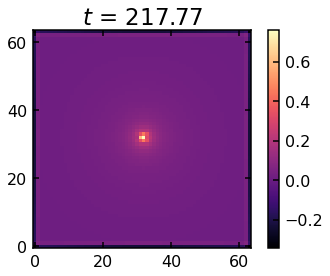

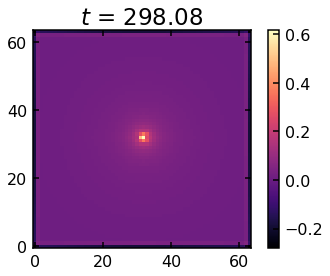

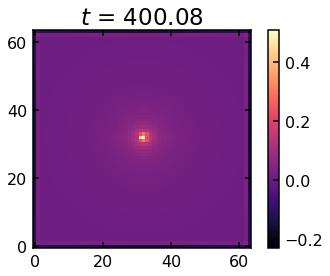

In [15]:
for i in range(len(allit)):
    plt.imshow(Theta[i][int(param['Nx']/2),:,:])
    idx = np.argmin(abs(fallt['it'] - allit[i]))
    plt.title(r'$t$ = ' + '{:.2f}'.format(fallt['t'][idx]))
    plt.colorbar()
    plt.show()